# Import

In [1]:
from SALib.analyze import sobol
from SALib import ProblemSpec

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)

# Dataset

In [2]:
from configurations.config import *

config = ExperimentConfig(experiment=ExperimentType.ELECTRICITY)
formatter = config.data_provider

## Load

In [460]:
df = formatter.load()
df.head(3)

Loading datasets\electricity\hourly_electricity.csv
Feature column, Data type, Input type, Current type
id categorical id object
hours_from_start int time float64
power_usage float target float64
hour int known int64
day_of_week int known int64
categorical_id categorical static object
power_usage         float64
hours_from_start      int32
days_from_start       int64
categorical_id       object
date                 object
id                   object
hour                  int32
day                   int64
day_of_week           int32
month                 int64
dtype: object


,power_usage,hours_from_start,days_from_start,categorical_id,date,id,hour,day,day_of_week,month
0,2.538071,26304,1096,MT_001,2014-01-01 00:00:00,MT_001,0,1,2,1
1,2.855330,26305,1096,MT_001,2014-01-01 01:00:00,MT_001,1,1,2,1
2,2.855330,26306,1096,MT_001,2014-01-01 02:00:00,MT_001,2,1,2,1


In [461]:
# choosing a subsample
df = df[df['id'].isin(df['id'].unique()[:100])]

## Split

In [462]:
train, validation, test = formatter.split(df)
print(train.shape, validation.shape, test.shape)

(525600, 10) (74400, 10) (33600, 10)


# Problem Specs

In [6]:
# ensure only integer or float values are used here
sensitive_features = ['hour', 'day_of_week']
dists = ['unif', 'unif']

# https://salib.readthedocs.io/en/latest/user_guide/advanced.html#generating-alternate-distributions
# the default is to assume all inputs are uniformly distributed.
bounds = []
for index, feature in enumerate(sensitive_features):
    # uniform distribution
    # e.g. [-np.pi, np.pi] defines the lower and upper bounds
    if dists[index] == 'unif':
        bound = [df[feature].min(), df[feature].max()]

    # triangular with lower and upper bounds, as well as
    # location of peak The location of peak is in percentage of width
    elif dists[index] == 'triag':
        bound = [df[feature].min(), df[feature].max(), (df[feature].min(), df[feature].max())/2]
    
    # norm or lognorm with mean and standard deviation
    else:
        bound = [df[feature].mean(), df[feature].std()]
    bounds.append(bound)

print(bounds)

[[0, 23], [0, 6]]


In [463]:
sp = ProblemSpec({
    "num_vars": len(sensitive_features),
    "names": sensitive_features,
    "bounds": bounds,
    # https://salib.readthedocs.io/en/latest/user_guide/advanced.html#generating-alternate-distributions
    "dists": dists, 
    # "outputs": config.data_provider.targets,
    # 'groups': None, # if input features have groups
    'sample_scaled': True
})

The samples, results, and results of analysis are all held inside the sp object. If needed, these may be extracted via their respective attributes.

# Population

In [464]:
data = train.copy()
# the last `horizon` num of time indices are not used as input
# which is from (max_time_index - horizon + 1) to max_time_index
# so any input perturbation must be done at or before (max_time_index - horizon)
max_input_time_index = data[
    formatter.time_index[0]
].max() - formatter.parameters['horizon']

# output doesn't start unless you have at least `window` num of time indices
min_output_time_index = data[
    formatter.time_index[0]
].min() + formatter.parameters['window']

# don't reset the index of input_data, 
# we'll use it to replace values of data later
input_data = data[
    (data[formatter.time_index[0]] >= (min_output_time_index-1)) &
    (data[formatter.time_index[0]] <= max_input_time_index)
][formatter.group_id + formatter.time_index] # we only need the id and time index columns 

population_size = input_data.shape[0]
print(f'Data from time index {min_output_time_index-1} to\
      {max_input_time_index} has impact to all horizon.')

max_possible_N = int(population_size / (2 * sp['num_vars'] + 2))
print(f"So you can replace max {population_size} samples at a time using \
      N {max_possible_N}.")

Data from time index 26471 to      31535 has impact to all horizon.
So you can replace max 506500 samples at a time using       N 84416.


# Sample

Next, we generate the samples. Since we are performing a Sobol’ sensitivity analysis, we need to generate samples using the Saltelli sampler, as shown below. 

Here, param_values is a NumPy matrix. If we run param_values.shape, we see that the matrix is 4096 by 1. The Saltelli sampler generated 4096 samples. The Saltelli sampler generates $N \times (2D + 2)$ samples, where in this example $N$ is 1024 (the argument we supplied) and $D$ is 1 (the number of model inputs). The keyword argument `calc_second_order=False` will exclude second-order indices, resulting in a smaller sample matrix with 
rows instead.

In [465]:
N = 2**16
number_of_samples = N * (2 * sp['num_vars'] + 2)
print(f'Generating {number_of_samples} samples.')
sp.sample_sobol(N)

Generating 393216 samples.


{'num_vars': 2,
 'names': ['hour', 'day_of_week'],
 'bounds': [[0, 23], [0, 6]],
 'dists': ['unif', 'unif'],
 'sample_scaled': True,
 'groups': None}

In [466]:
population_size = input_data.shape[0]
assert number_of_samples <= population_size, \
    ValueError('Replacement sample size must be <= than the destination population size.')
print(f'Randomly choosing among {population_size} to replace {number_of_samples}.')

# note the reset index
sample_index = input_data.sample(
    number_of_samples, random_state=config.seed
).index

data.loc[sample_index, sensitive_features] = sp.samples

Randomly choosing among 506500 to replace 393216.


# Evaluate

## Load model

In [156]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from utils.data import create_TimeSeriesDataSet

parameters = config.model_parameters(ModelType.TFT)

Experimental config found for electricity.
Fetching parameters from available models ['tft'].


In [157]:
from pytorch_forecasting import TemporalFusionTransformer
from utils.model import get_best_model_path

model = TemporalFusionTransformer.load_from_checkpoint(
    get_best_model_path(config.experiment_folder)
)

Checkpoint model best-epoch=0.ckpt.


## Evaluate

In [467]:
show_progress_bar = True

_, dataloader = create_TimeSeriesDataSet(
    data, formatter, parameters['batch_size']
)
predictions, prediction_index = model.predict(
    dataloader, return_index=True, 
    show_progress_bar=show_progress_bar
)

Predict:   0%|          | 0/1979 [00:00<?, ? batches/s]

In [468]:
prediction_df = []
for index, prediction in enumerate(predictions):
    temp = prediction_index.copy()
    target = formatter.targets[index]
    temp[
        [f'{target}_{i}' for i in range(formatter.parameters['horizon'])]
    ] = prediction
    prediction_df.append(temp)

prediction_df = pd.concat(prediction_df)

In [205]:
from data_provider.base import BaseDataFormatter

def extract_Y(
    input_data: pd.DataFrame,
    prediction_df: pd.DataFrame,
    sample_index:pd.Index,
    window_index:int =-1, 
    horizon_index:int =0,
    formatter: BaseDataFormatter = formatter
) -> np.ndarray:
    """_summary_

    Args:
        input_data (pd.DataFrame): _description_
        prediction_df (pd.DataFrame): _description_
        window_index (int, optional): _description_. Defaults to -1.
        horizon_index (int, optional): _description_. Defaults to 0.
        formatter (BaseDataFormatter, optional): _description_. Defaults to formatter.

    Returns:
        _type_: _description_
    """    
    window = formatter.parameters['window'] 
    horizon = formatter.parameters['horizon']
    assert (- window) <= window_index < 0, \
        ValueError(f'Window time step must be within [-{window} ,-1]. Found {window_index}.')

    assert 0 <= horizon_index < horizon,\
        ValueError(f'Horizon time step must be within [0, {horizon}). Found {horizon_index}.')

    id = formatter.group_id + formatter.time_index
    input_data = input_data.loc[sample_index, id]

    input_data[formatter.time_index] += abs(window_index)
    target_columns = [
        f'{target}_{horizon_index}' for target in formatter.targets
    ]
    if len(target_columns) == 1:
        target_columns = target_columns[0]

    merged = input_data.merge(prediction_df, on=id, how='inner')

    return merged[target_columns].values

In [469]:
Y = extract_Y(input_data, prediction_df, sample_index)
sp.set_results(Y)


{'num_vars': 2,
 'names': ['hour', 'day_of_week'],
 'bounds': [[0, 23], [0, 6]],
 'dists': ['unif', 'unif'],
 'sample_scaled': True,
 'groups': None,
 'outputs': ['Y']}

# Analyze

We use sobol.analyze, which will compute first, second, and total-order indices. `Si` is a Python dict with the keys "S1", "S2", "ST", "S1_conf", "S2_conf", and "ST_conf". The `_conf` keys store the corresponding confidence intervals, typically with a confidence level of 95%. Use the keyword argument `print_to_console=True` to print all indices. Or, we can print the individual values from `Si` as shown below

In [470]:
sp.analyze_sobol()
print(sp)

Samples:
	2 parameters: ['hour', 'day_of_week']
	393216 evaluations 

Outputs:
	1 outputs: ['Y']
	393216 evaluations 

Analysis:
                   ST   ST_conf
hour         0.976974  0.028696
day_of_week  0.996300  0.027273 

                   S1   S1_conf
hour        -0.004068  0.010495
day_of_week -0.001436  0.010442 

                           S2   S2_conf
(hour, day_of_week) -0.001391  0.014494 




# Plotting

The plot() method returns matplotlib axes objects to allow later adjustment.

In [232]:
from classes.PlotConfig import *

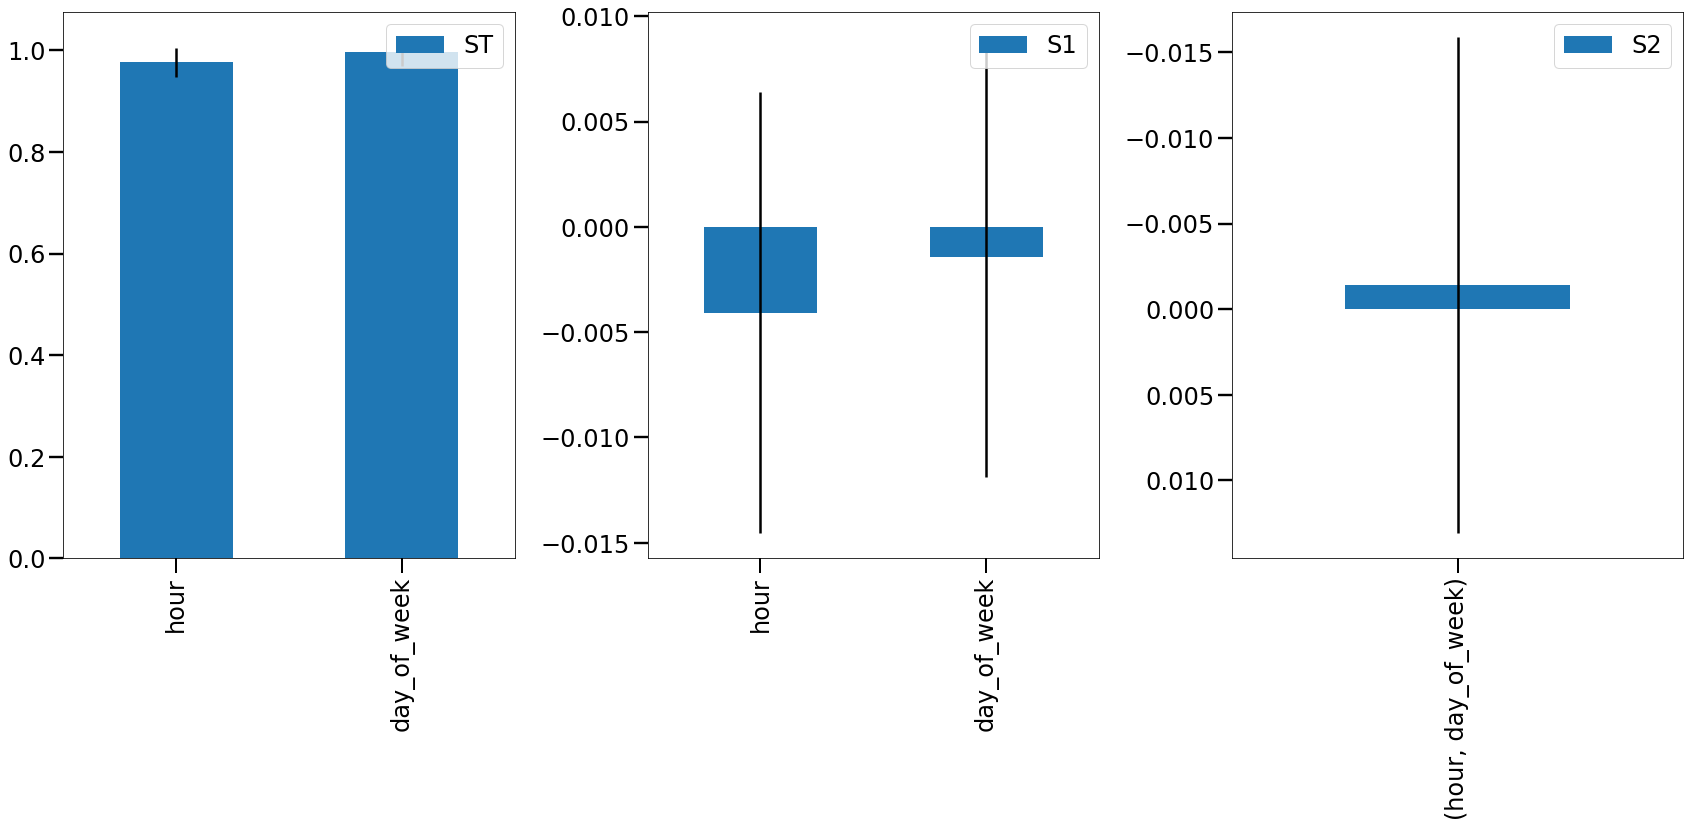

In [471]:
axes = sp.plot()

#     ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
# axes[0].tick_params(axis='x', labelrotation=45)
# axes[0].set_yscale('log')
fig = plt.gcf()  # get current figure
# fig.autofmt_xdate(rotation=45)
fig.set_size_inches(24, 12)
fig.gca().invert_yaxis()
plt.tight_layout()

<AxesSubplot:title={'center':'Y'}>

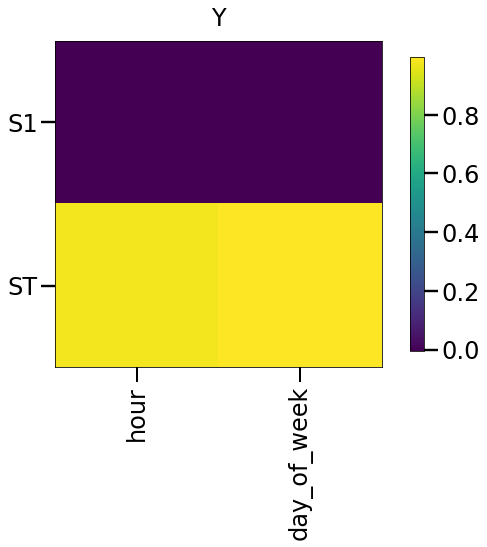

In [472]:
sp.heatmap()

In [334]:
# def plot(df, figsize=(10, 4)):
#     fig, ax = plt.subplots(figsize=figsize)
#     plt.barh(df.index, df.iloc[:, -2], height=0.5, xerr=df.iloc[:, -1])
#     # ax.barh()
#     # show top values
#     plt.gca().invert_yaxis()

#     # Add x, y gridlines
#     # ax.grid(visible= True, color ='grey',
#     #         linestyle ='--', linewidth = .5,
#     #         alpha =1)

#     # Add annotation to bars
#     for i in ax.patches:
#         plt.text(i.get_width() + 0.02, i.get_y()+0.15,
#                 str(round((i.get_width()), 2)),
#                 fontsize = 24, # fontweight ='bold',
#                 color ='black')
    
#     plt.tight_layout()
#     plt.show()

# Dump

In [225]:
def dump(
    df:pd.DataFrame, filename:str, 
    directory:str=config.experiment_folder
):
    # the index for this case is important
    df = df.reset_index().round(6)
    df.to_csv(os.path.join(directory, filename), index=False)

In [473]:
total_Si, first_Si, second_Si = sp.to_df()
dump(total_Si, 'total_Si.csv')
dump(first_Si, 'first_Si.csv')
dump(second_Si, 'second_Si.csv')

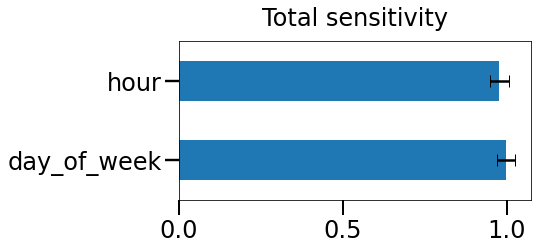

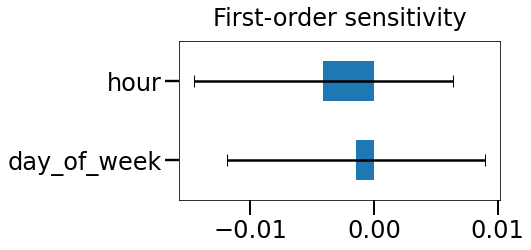

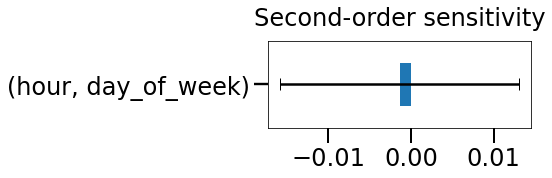

In [474]:
# https://www.geeksforgeeks.org/bar-plot-in-matplotlib/
for title, key, df_si in zip(
    ['Total', 'First-order', 'Second-order'],
    ['ST', 'S1', 'S2'], [total_Si, first_Si, second_Si]
):
    ax = df_si.plot.barh(
        y=key, xerr=f'{key}_conf', figsize=(8, 2 + len(df_si.index)), 
        legend=False, capsize=6
    )
    ax.set_title(f'{title} sensitivity')
    ax.invert_yaxis()
    # for i in ax.patches:
    #     plt.text(i.get_width() + 0.02, i.get_y()+0.15,
    #             str(round((i.get_width()), 2)),
    #             fontsize = 24, # fontweight ='bold',
    #             color ='black')
    plt.tight_layout()
    plt.savefig(os.path.join(config.experiment_folder, f'{title}.jpg'), dpi=200)